The following code leverages features extracted from various biological sources, including molecular structures, amino acid sequences, ligand molecular descriptor features, and expression profiles of transcription factors (TFs) and genomic markers. This comprehensive dataset is utilized for training the ResisenseNet model, which aims to predict drug sensitivity and resistance profiles.

In [ ]:
please refer to the below link for the dataset i have utlised

https://dorothea.opentargets.io/#/

Below program demonstrates a 1D-CNN + MLP based model without hyperparameter optimization for binary class classification

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import numpy as np

#LOAD THE DATA
seqembed_path = "seq_class.csv"
molembed_path = "mol_class.csv"
train_path = "train_class.csv"
test_path = "test_class.csv"
tensorboard_path = "~/LDH_IC50_Data"
model_save_path = "~/LDH_IC50_Data"



seqembed = pd.read_csv(seqembed_path).set_index("id").iloc[:, 1:]
molembed = pd.read_csv(molembed_path).set_index("id").iloc[:, 1:]
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train["target"] = label_encoder.fit_transform(train["target"])
test["target"] = label_encoder.transform(test["target"])

# Prepare datasets
train_seq = torch.tensor(np.array(seqembed.loc[train["seq"]]), dtype=torch.float32)
train_mol = torch.tensor(np.array(molembed.loc[train["mol"]]), dtype=torch.float32)
train_target = torch.tensor(train["target"].values, dtype=torch.long)

test_seq = torch.tensor(np.array(seqembed.loc[test["seq"]]), dtype=torch.float32)
test_mol = torch.tensor(np.array(molembed.loc[test["mol"]]), dtype=torch.float32)
test_target = torch.tensor(test["target"].values, dtype=torch.long)

train_dataset = TensorDataset(train_mol, train_seq, train_target)
test_dataset = TensorDataset(test_mol, test_seq, test_target)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define the DeepLPI model
class DeepLPI(nn.Module):
    def __init__(self, molshape, seqshape, num_classes, dropout=0.3):
        super(DeepLPI, self).__init__()
        self.molshape = molshape
        self.seqshape = seqshape

        self.molcnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.seqcnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.fc = nn.Sequential(
            nn.Linear(16 * (molshape // 4 + seqshape // 4), 128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, mol, seq):
        mol = self.molcnn(mol.unsqueeze(1))
        seq = self.seqcnn(seq.unsqueeze(1))
        combined = torch.cat((mol.flatten(1), seq.flatten(1)), dim=1)
        return self.fc(combined)

# Initialize the model
model = DeepLPI(molshape=mol_embed_dim, seqshape=seq_embed_dim, num_classes=3, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0
    for mol, seq, target in train_loader:
        optimizer.zero_grad()
        output = model(mol, seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for mol, seq, target in test_loader:
        output = model(mol, seq)
        preds = torch.argmax(output, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Validation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Epoch 1, Loss: 1.1615481227636337
Epoch 2, Loss: 0.8140880763530731
Epoch 3, Loss: 0.6996964886784554
Epoch 4, Loss: 0.677908182144165
Epoch 5, Loss: 0.6709074005484581
Epoch 6, Loss: 0.6055079773068428
Epoch 7, Loss: 0.5781704559922218
Epoch 8, Loss: 0.5448079332709312
Epoch 9, Loss: 0.5064694136381149
Epoch 10, Loss: 0.4637419059872627
Epoch 11, Loss: 0.44072772935032845
Epoch 12, Loss: 0.40574174001812935
Epoch 13, Loss: 0.40061788260936737
Epoch 14, Loss: 0.3979511111974716
Epoch 15, Loss: 0.38108543679118156
Epoch 16, Loss: 0.3381016030907631
Epoch 17, Loss: 0.3207923658192158
Epoch 18, Loss: 0.3623073399066925
Epoch 19, Loss: 0.36209145188331604
Epoch 20, Loss: 0.31423184275627136
Epoch 21, Loss: 0.31443721801042557
Epoch 22, Loss: 0.31386252120137215
Epoch 23, Loss: 0.29766346141695976
Epoch 24, Loss: 0.26206780783832073
Epoch 25, Loss: 0.2537679336965084
Epoch 26, Loss: 0.24366099759936333
Epoch 27, Loss: 0.254117613658309
Epoch 28, Loss: 0.24188548140227795
Epoch 29, Loss: 0.2

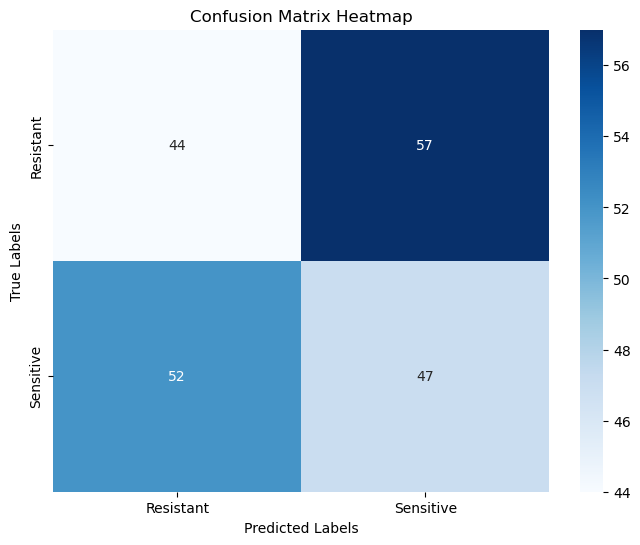

Accuracy: 0.4550
Precision: 0.4519
Recall: 0.4747
F1-Score: 0.4631
ROC-AUC: 0.4552


In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_fscore_support


# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Resistant', 'Sensitive'], yticklabels=['Resistant', 'Sensitive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Calculate binary classification metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
roc_auc = roc_auc_score(all_labels, all_preds)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

BELOW PROGRAM DEMONSTRATES THE HYPERPARAMETER OPTIMIZATION FOR THE ABOVE MENTIONED 1D-CNN + MLP  based model

In [28]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Define the search space
search_space = {
    'lr': hp.loguniform('lr', np.log(1e-4), np.log(1e-1)),
    'dropout': hp.uniform('dropout', 0.1, 0.5),
    'batch_size': hp.choice('batch_size', [32, 64, 128, 256]),
    'num_filters': hp.choice('num_filters', [8, 16, 32, 64]),
}

# Objective function
def objective(params):
    batch_size = params['batch_size']
    lr = params['lr']
    dropout = params['dropout']
    num_filters = params['num_filters']

    # Update DataLoader with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the model
    class DeepLPI(nn.Module):
        def __init__(self, molshape, seqshape, num_classes):
            super(DeepLPI, self).__init__()
            self.molcnn = nn.Sequential(
                nn.Conv1d(1, num_filters, kernel_size=7, stride=2, padding=3),
                nn.ReLU(),
                nn.MaxPool1d(2)
            )
            self.seqcnn = nn.Sequential(
                nn.Conv1d(1, num_filters, kernel_size=7, stride=2, padding=3),
                nn.ReLU(),
                nn.MaxPool1d(2)
            )
            self.fc = nn.Sequential(
                nn.Linear(num_filters * (mol_embed_dim // 4 + seq_embed_dim // 4), 128),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(128, num_classes)
            )

        def forward(self, mol, seq):
            mol = self.molcnn(mol.unsqueeze(1))
            seq = self.seqcnn(seq.unsqueeze(1))
            combined = torch.cat((mol.flatten(1), seq.flatten(1)), dim=1)
            return self.fc(combined)

    # Initialize model, loss, and optimizer
    model = DeepLPI(molshape=train_mol.shape[1], seqshape=train_seq.shape[1], num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    for epoch in range(10):  # Reduce epochs for faster tuning
        model.train()
        for mol, seq, target in train_loader:
            optimizer.zero_grad()
            output = model(mol, seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for mol, seq, target in test_loader:
            output = model(mol, seq)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Calculate the F1 score
    _, _, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return {'loss': -f1, 'status': STATUS_OK}

# Run hyperparameter optimization
trials = Trials()
best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best Hyperparameters:", best_params)


  2%|▏         | 1/50 [00:24<20:23, 24.97s/trial, best loss: -0.3389036544850498]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



  8%|▊         | 4/50 [00:42<06:52,  8.98s/trial, best loss: -0.43820855818195636]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 14%|█▍        | 7/50 [01:24<09:12, 12.84s/trial, best loss: -0.5037711577522004] 

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 18%|█▊        | 9/50 [01:48<09:04, 13.28s/trial, best loss: -0.5037711577522004]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 24%|██▍       | 12/50 [02:28<08:47, 13.88s/trial, best loss: -0.5148180840689155]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 26%|██▌       | 13/50 [02:30<06:18, 10.22s/trial, best loss: -0.5148180840689155]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 36%|███▌      | 18/50 [03:00<03:05,  5.79s/trial, best loss: -0.5148180840689155]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 40%|████      | 20/50 [03:08<02:26,  4.88s/trial, best loss: -0.5148180840689155]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 48%|████▊     | 24/50 [03:48<04:47, 11.06s/trial, best loss: -0.5148180840689155]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 58%|█████▊    | 29/50 [04:49<04:14, 12.11s/trial, best loss: -0.5148180840689155]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 66%|██████▌   | 33/50 [05:37<03:16, 11.57s/trial, best loss: -0.5148180840689155]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 72%|███████▏  | 36/50 [06:01<02:19,  9.96s/trial, best loss: -0.5148180840689155]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 84%|████████▍ | 42/50 [07:05<01:27, 10.95s/trial, best loss: -0.5148180840689155]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



100%|██████████| 50/50 [08:02<00:00,  9.65s/trial, best loss: -0.5148180840689155]
Best Hyperparameters: {'batch_size': 2, 'dropout': 0.1809874058725369, 'lr': 0.0025966607938469736, 'num_filters': 3}


BELOW PROGRAM DEMONSTRATES THE HYPERPARAMETER OPTIMIZATION WITH THE CHANGE IN LOSS TRENDS FOR EACH COMBINATION OF HYERPARAMETERS USED FROM THE PROVIDED SPACE FOR THE ABOVE MENTIONED 1D-CNN + MLP  based model

In [30]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np

# Define the search space
search_space = {
    'lr': hp.loguniform('lr', np.log(1e-4), np.log(1e-1)),
    'dropout': hp.uniform('dropout', 0.1, 0.5),
    'batch_size': hp.choice('batch_size', [32, 64, 128, 256]),
    'num_filters': hp.choice('num_filters', [8, 16, 32, 64]),
}

# Objective function
def objective(params):
    batch_size = params['batch_size']
    lr = params['lr']
    dropout = params['dropout']
    num_filters = params['num_filters']

    # Update DataLoader with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the model
    class ResisenseNet(nn.Module):
        def __init__(self, molshape, seqshape, num_classes):
            super(DeepLPI, self).__init__()
            self.molcnn = nn.Sequential(
                nn.Conv1d(1, num_filters, kernel_size=7, stride=2, padding=3),
                nn.ReLU(),
                nn.MaxPool1d(2)
            )
            self.seqcnn = nn.Sequential(
                nn.Conv1d(1, num_filters, kernel_size=7, stride=2, padding=3),
                nn.ReLU(),
                nn.MaxPool1d(2)
            )
            self.fc = nn.Sequential(
                nn.Linear(num_filters * (mol_embed_dim // 4 + seq_embed_dim // 4), 128),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(128, num_classes)
            )

        def forward(self, mol, seq):
            mol = self.molcnn(mol.unsqueeze(1))
            seq = self.seqcnn(seq.unsqueeze(1))
            combined = torch.cat((mol.flatten(1), seq.flatten(1)), dim=1)
            return self.fc(combined)

    # Initialize model, loss, and optimizer
    model = DeepLPI(molshape=train_mol.shape[1], seqshape=train_seq.shape[1], num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    for epoch in range(10):  # Reduce epochs for faster tuning
        model.train()
        for mol, seq, target in train_loader:
            optimizer.zero_grad()
            output = model(mol, seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for mol, seq, target in test_loader:
            output = model(mol, seq)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Calculate the F1 score
    _, _, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    loss = -f1  # Loss for hyperopt (negative F1 score)
    
    # Print hyperparameters and loss
    print(f"Params: {params}, Loss: {loss:.4f}")
    
    return {'loss': loss, 'status': STATUS_OK}

# Run hyperparameter optimization
trials = Trials()
best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print all losses for each combination
print("\nLoss for each trial:")
for i, trial in enumerate(trials.trials):
    print(f"Trial {i + 1}: Loss = {trial['result']['loss']:.4f}, Params = {trial['misc']['vals']}")
    
print("\nBest Hyperparameters:", best_params)


Params: {'batch_size': 128, 'dropout': 0.38725074019855954, 'lr': 0.0020458451959050744, 'num_filters': 32}, Loss: -0.3389
  2%|▏         | 1/50 [00:05<04:53,  6.00s/trial, best loss: -0.3389036544850498]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 32, 'dropout': 0.2216995192358675, 'lr': 0.06820321394504959, 'num_filters': 64}, Loss: -0.3278
  4%|▍         | 2/50 [00:25<11:06, 13.89s/trial, best loss: -0.3389036544850498]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 64, 'dropout': 0.4141034017405224, 'lr': 0.004580163825511926, 'num_filters': 32}, Loss: -0.4893
Params: {'batch_size': 32, 'dropout': 0.4302450673701175, 'lr': 0.0002418844537504934, 'num_filters': 8}, Loss: -0.3359
Params: {'batch_size': 256, 'dropout': 0.3020908326054586, 'lr': 0.0021550530920165954, 'num_filters': 64}, Loss: -0.3388
Params: {'batch_size': 64, 'dropout': 0.3215793329563936, 'lr': 0.006119411118835024, 'num_filters': 16}, Loss: -0.4694
Params: {'batch_size': 32, 'dropout': 0.45937361592823944, 'lr': 0.006787930876641105, 'num_filters': 8}, Loss: -0.4876
Params: {'batch_size': 128, 'dropout': 0.12960551658478214, 'lr': 0.0024888373604465136, 'num_filters': 8}, Loss: -0.4267
Params: {'batch_size': 256, 'dropout': 0.41751952400820425, 'lr': 0.0002200232211150878, 'num_filters': 16}, Loss: -0.4080
Params: {'batch_size': 128, 'dropout': 0.42670451101126483, 'lr': 0.023602001289805847, 'num_filters': 16}, Loss: -0.3389
 20%|██        | 10/50 [01:02<0

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 32, 'dropout': 0.4545488684754607, 'lr': 0.007693056715405957, 'num_filters': 64}, Loss: -0.4842
Params: {'batch_size': 128, 'dropout': 0.49364542804519906, 'lr': 0.0031118608815415847, 'num_filters': 16}, Loss: -0.3389
 24%|██▍       | 12/50 [01:28<04:51,  7.67s/trial, best loss: -0.48925831202046033]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 32, 'dropout': 0.13554045932323888, 'lr': 0.00016888184713681817, 'num_filters': 16}, Loss: -0.4871
Params: {'batch_size': 256, 'dropout': 0.38666194133331844, 'lr': 0.008560630249312825, 'num_filters': 8}, Loss: -0.3389
 28%|██▊       | 14/50 [01:34<03:11,  5.32s/trial, best loss: -0.48925831202046033]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 128, 'dropout': 0.2340404881482595, 'lr': 0.057385915548528434, 'num_filters': 64}, Loss: -0.3389
 30%|███       | 15/50 [01:49<04:46,  8.19s/trial, best loss: -0.48925831202046033]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 256, 'dropout': 0.3834690634249621, 'lr': 0.00787424386862511, 'num_filters': 64}, Loss: -0.3389
 32%|███▏      | 16/50 [02:01<05:20,  9.42s/trial, best loss: -0.48925831202046033]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 64, 'dropout': 0.14475197253756136, 'lr': 0.007654761693777719, 'num_filters': 8}, Loss: -0.4849
Params: {'batch_size': 128, 'dropout': 0.20222430492174448, 'lr': 0.04042780512555127, 'num_filters': 64}, Loss: -0.3389
 36%|███▌      | 18/50 [02:19<05:10,  9.69s/trial, best loss: -0.48925831202046033]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 128, 'dropout': 0.1107472726893855, 'lr': 0.0025184370935240233, 'num_filters': 32}, Loss: -0.4190
Params: {'batch_size': 64, 'dropout': 0.15617341277855107, 'lr': 0.0006143644207854076, 'num_filters': 32}, Loss: -0.4528
Params: {'batch_size': 64, 'dropout': 0.4675680585852679, 'lr': 0.0009537511397786128, 'num_filters': 32}, Loss: -0.4946
Params: {'batch_size': 64, 'dropout': 0.4935128306839805, 'lr': 0.00090102199472003, 'num_filters': 32}, Loss: -0.3389
 44%|████▍     | 22/50 [02:51<03:59,  8.56s/trial, best loss: -0.49455784865540964]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 64, 'dropout': 0.3327248862295756, 'lr': 0.0009049964289008739, 'num_filters': 32}, Loss: -0.4506
Params: {'batch_size': 64, 'dropout': 0.352749558106515, 'lr': 0.00045531757311600675, 'num_filters': 32}, Loss: -0.5048
Params: {'batch_size': 64, 'dropout': 0.3528812169070539, 'lr': 0.00041508500841872366, 'num_filters': 32}, Loss: -0.4258
Params: {'batch_size': 64, 'dropout': 0.26677288693737644, 'lr': 0.00010228520736571341, 'num_filters': 32}, Loss: -0.4311
Params: {'batch_size': 64, 'dropout': 0.27259100726339286, 'lr': 0.0013065945121569999, 'num_filters': 32}, Loss: -0.3922
Params: {'batch_size': 64, 'dropout': 0.46443459067104165, 'lr': 0.00037801890704545295, 'num_filters': 32}, Loss: -0.3389
 56%|█████▌    | 28/50 [03:40<03:04,  8.38s/trial, best loss: -0.5048143332249757]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 64, 'dropout': 0.3466677930474902, 'lr': 0.00013723250191984742, 'num_filters': 32}, Loss: -0.3278
 58%|█████▊    | 29/50 [03:48<02:50,  8.11s/trial, best loss: -0.5048143332249757]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 64, 'dropout': 0.37379521680125916, 'lr': 0.0004312441534919252, 'num_filters': 32}, Loss: -0.4388
Params: {'batch_size': 64, 'dropout': 0.49529139345636136, 'lr': 0.0012446689576367422, 'num_filters': 32}, Loss: -0.3523
Params: {'batch_size': 64, 'dropout': 0.2730219496725107, 'lr': 0.015119866415035236, 'num_filters': 32}, Loss: -0.4561
Params: {'batch_size': 64, 'dropout': 0.19381349170370568, 'lr': 0.0015480759485425933, 'num_filters': 32}, Loss: -0.4688
Params: {'batch_size': 256, 'dropout': 0.3997610200954101, 'lr': 0.0006460615327662532, 'num_filters': 32}, Loss: -0.3389
 68%|██████▊   | 34/50 [04:23<01:52,  7.04s/trial, best loss: -0.5048143332249757]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 32, 'dropout': 0.4437668811327083, 'lr': 0.0041444825265360315, 'num_filters': 32}, Loss: -0.3389
 70%|███████   | 35/50 [04:31<01:50,  7.37s/trial, best loss: -0.5048143332249757]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 64, 'dropout': 0.3076430937653935, 'lr': 0.00031453073052870837, 'num_filters': 8}, Loss: -0.4228
Params: {'batch_size': 32, 'dropout': 0.47602069559045096, 'lr': 0.0007666424481273993, 'num_filters': 32}, Loss: -0.4322
Params: {'batch_size': 64, 'dropout': 0.36607583132076305, 'lr': 0.00024011417634854458, 'num_filters': 16}, Loss: -0.4636
Params: {'batch_size': 256, 'dropout': 0.40276471824036947, 'lr': 0.0016960670649587355, 'num_filters': 64}, Loss: -0.4552
Params: {'batch_size': 64, 'dropout': 0.2524886026285481, 'lr': 0.0044395696404926225, 'num_filters': 8}, Loss: -0.4662
Params: {'batch_size': 32, 'dropout': 0.43023521625893335, 'lr': 0.00012373125963979688, 'num_filters': 32}, Loss: -0.3389
 82%|████████▏ | 41/50 [05:08<01:00,  6.69s/trial, best loss: -0.5048143332249757]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 64, 'dropout': 0.29303764908947183, 'lr': 0.0005178135819602567, 'num_filters': 16}, Loss: -0.4616
Params: {'batch_size': 256, 'dropout': 0.4783786906702731, 'lr': 0.0019492149726291434, 'num_filters': 32}, Loss: -0.4157
Params: {'batch_size': 128, 'dropout': 0.32399216015865817, 'lr': 0.00018596309686624022, 'num_filters': 8}, Loss: -0.3388
Params: {'batch_size': 32, 'dropout': 0.44623489340288647, 'lr': 0.00031661906151619104, 'num_filters': 64}, Loss: -0.3389
 90%|█████████ | 45/50 [05:40<00:47,  9.44s/trial, best loss: -0.5048143332249757]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 64, 'dropout': 0.4184729853782546, 'lr': 0.012140441796914555, 'num_filters': 16}, Loss: -0.4470
Params: {'batch_size': 256, 'dropout': 0.3513771418741553, 'lr': 0.0011705299474723079, 'num_filters': 32}, Loss: -0.4532
Params: {'batch_size': 128, 'dropout': 0.1818953150704103, 'lr': 0.003019488651927171, 'num_filters': 64}, Loss: -0.4758
Params: {'batch_size': 64, 'dropout': 0.22193194979801378, 'lr': 0.005753025958458732, 'num_filters': 16}, Loss: -0.3389
 98%|█████████▊| 49/50 [06:11<00:08,  8.15s/trial, best loss: -0.5048143332249757]

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Params: {'batch_size': 32, 'dropout': 0.3935246229695719, 'lr': 0.00016820846174565697, 'num_filters': 8}, Loss: -0.3389
100%|██████████| 50/50 [06:13<00:00,  7.48s/trial, best loss: -0.5048143332249757]

Loss for each trial:
Trial 1: Loss = -0.3389, Params = {'batch_size': [2], 'dropout': [0.38725074019855954], 'lr': [0.0020458451959050744], 'num_filters': [2]}
Trial 2: Loss = -0.3278, Params = {'batch_size': [0], 'dropout': [0.2216995192358675], 'lr': [0.06820321394504959], 'num_filters': [3]}
Trial 3: Loss = -0.4893, Params = {'batch_size': [1], 'dropout': [0.4141034017405224], 'lr': [0.004580163825511926], 'num_filters': [2]}
Trial 4: Loss = -0.3359, Params = {'batch_size': [0], 'dropout': [0.4302450673701175], 'lr': [0.0002418844537504934], 'num_filters': [0]}
Trial 5: Loss = -0.3388, Params = {'batch_size': [3], 'dropout': [0.3020908326054586], 'lr': [0.0021550530920165954], 'num_filters': [3]}
Trial 6: Loss = -0.4694, Params = {'batch_size': [1], 'dropout': [0.3215793329563936],

/home/anush/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

